In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

<h3>Load data</h3>

In [2]:
iris = load_iris(as_frame=True)
df = pd.concat([iris.data, iris.target], axis=1)
df = df[df['target'].isin([0, 1])]

In [3]:
X = df[['sepal length (cm)', 'petal length (cm)']].values
y = df['target'].values

In [4]:
print(X.shape)
print(y.shape)

(100, 2)
(100,)


### Train-test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(80, 2)
(80,)
(20, 2)
(20,)
(array([0, 1]), array([40, 40]))
(array([0, 1]), array([10, 10]))


### Feature scaling

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Adaline SGD

In [32]:
class AdalineSGD:
    """
    ADAptive LInear NEuron classifier.
    
    Parameters
    ----------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight initialization
    
    Attributes
    ----------
    w_ : 1D-array
      Weights after fitting (optimization)
    b_ : scalar
      Bias (intercept) after fitting (optimization)
    errors_ : list
      MSE loss function values in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        self.initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self.update_weights(xi, target))
            self.losses_.append(np.mean(losses))
        return self
                 
    def _shuffle(self, X, y):
        random_indices = self.rgen.permutation(len(y))
        return X[random_indices], y[random_indices] 
        
    def initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.0)
        
    def update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))  # σ(z)
        error = target - output
        self.w_ += self.eta * error * xi
        self.b_ += self.eta * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        return X @ self.w_ + self.b_
    
    def activation(self, X):
        return X  # Linear activation function
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

- In Python, when you assign something to `self.variable_name`, it becomes an **instance attribute**. It doesn't matter if it was created in $\, \text{__init__} \,$ or inside another method like `fit`; once that line of code runs, the attribute is attached to that specific object and is accessible by any other method using self.

<br>

- In Python, prefixing a method or variable name with a single underscore (e.g., `_shuffle`) is a widely accepted naming convention that signals **internal use.**
- It tells the user of your class: "This is a helper function used internally by the class. You shouldn't need to call this directly from outside."
- In our case, _shuffle is called inside the fit method, but a user shouldn't manually shuffle the data via this method.
- The single underscore has one actual functional effect in Python. If you have a module (e.g., algorithms.py) and you use a "wildcard import": `from algorithms import *`, then any functions or classes starting with _ will not be imported. This helps keep the namespace clean by only exposing the intended API.

### Model training

In [33]:
def viz_training_progress(clf):
    mse = clf.losses_
    eta = clf.eta
    r = np.arange(1, len(mse) + 1)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(r, mse, marker='o', zorder=2, color='black')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss function')
    ax.set_title(f'Learning rate: {eta}')
    ax.grid(True, alpha=0.3, zorder=1);

In [34]:
def plot_decision_boundary(X, y, clf):
    fig, ax = plt.subplots(figsize=(8,6))
    
    # Create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 0].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    
    # Make a Prediction on every grid point
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.Blues)
    
    # Define markers and colors for each (both) class
    markers = ['o', '^']
    colors = ['black', 'orange']
    labels = np.unique(y)
    
    # Plot the original data (each class with a different marker and color)
    for i, label in enumerate(labels):
        X_sub = X[y == label]
        ax.scatter(X_sub[:, 0], X_sub[:, 1], marker=markers[i], color=colors[i])
    ax.set_xlabel('Sepal length (cm)')
    ax.set_ylabel('Petal length (cm)')
    ax.set_title('Adaline classifier decision boundary')
    plt.tight_layout();

In [35]:
ada = AdalineSGD(eta=0.01, n_iter=15, random_state=1).fit(X_train_scaled, y_train)

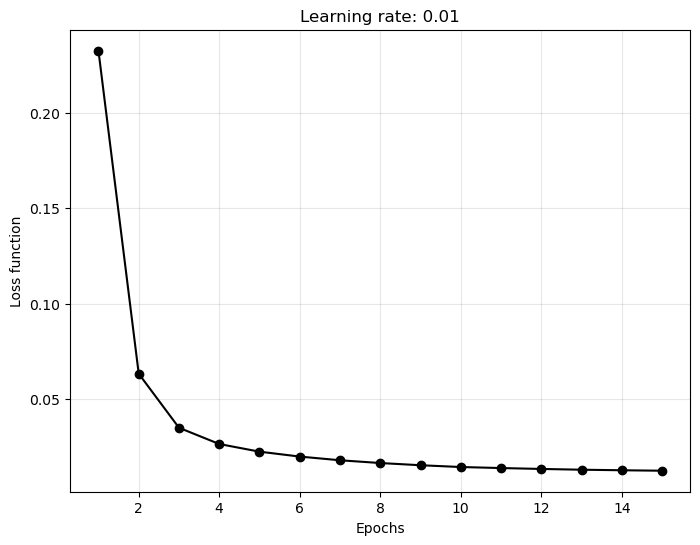

In [36]:
viz_training_progress(clf=ada)

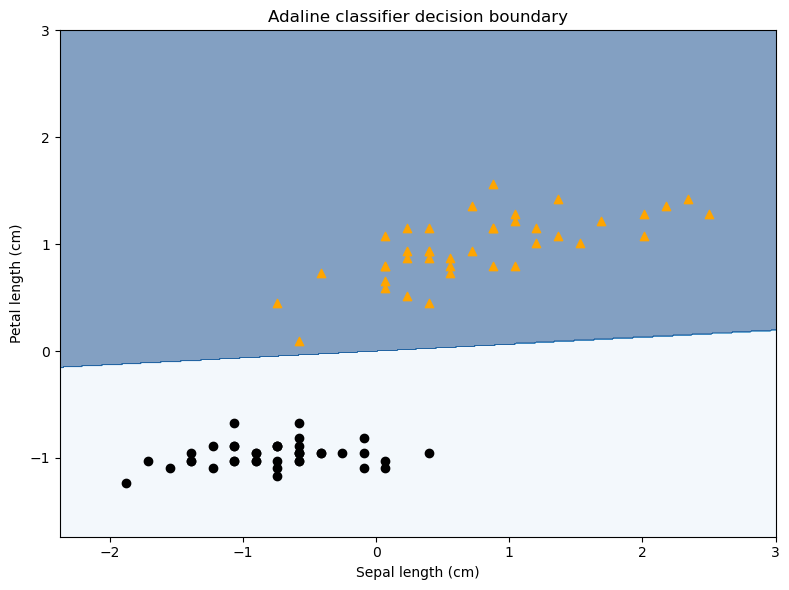

In [38]:
plot_decision_boundary(X=X_train_scaled, y=y_train, clf=ada)

In [42]:
(ada.predict(X_train_scaled) == y_train).sum() / len(y_train)

np.float64(1.0)

In [47]:
(ada.predict(X_test_scaled) == y_test).sum() / len(y_test)

np.float64(1.0)